In [1]:
import os
os.chdir('..')
from team_functions import *

In [2]:
today = date.today()
print(f'Today is: {today}')

Today is: 2024-02-04


In [3]:
tonight_odds = pd.read_excel('Predictions/games_odds.xlsx', sheet_name='Tonight')
prev_odds = pd.read_excel('Predictions/games_odds.xlsx', sheet_name='Previous')

In [4]:
prev_odds

,date,visitor,local,v_line,l_line,Results
0,2024-02-03,BRK,PHI,2.420000,1.588235,1
1,2024-02-03,GSW,ATL,2.200000,1.704225,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1
3,2024-02-03,LAL,NYK,2.640000,1.505051,1
4,2024-02-03,MIL,DAL,1.540541,2.540000,1
5,2024-02-03,CLE,SAS,1.219780,4.500000,1


In [5]:
games_to_pred = []
teams, opps = prev_odds['visitor'], prev_odds['local']
for team, opp in zip(teams, opps):
    team_row = {}
    team_df = pd.read_excel(f'data/CurrentSeason/{team}.xlsx')
    
    team_row['Game'] = team_df['Game'].iloc[-1] + 1
    team_row['Date'] = prev_odds.loc[prev_odds['visitor'] == team, 'date'].iloc[0]
    team_row['Streak'] = team_df['Streak'].iloc[-1]

    team_cols = ['Pts', 'Pace', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in team_cols:
        team_row[col] = team_df[col].mean()

    opp_df = pd.read_excel(f'data/CurrentSeason/{opp}.xlsx')
    team_row['OppID'] = mapTeamID(opp)
    
    opp_cols = ['Pts', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in opp_cols:
        team_row['Opp'+col] = opp_df[col].mean()
        
    team_row['Location'] = 0
    
    team_row['Month'] = team_row['Date'].month
    team_row['DayOfWeek'] = team_row['Date'].weekday()
    team_row['DaysOfRest'] = (team_row['Date'] - team_df['Date'].iloc[-1]).days
    
    team_row['TeamID'] = mapTeamID(team)
    team_row['Season'] = 2024
    
    games_to_pred.append(team_row)
    
games_df = pd.DataFrame(games_to_pred)

In [6]:
games_df

,Game,Date,Streak,Pts,Pace,eFG,TOV,ORB,FTR,ORT,...,OppTOV,OppORB,OppFTR,OppORT,Location,Month,DayOfWeek,DaysOfRest,TeamID,Season
0,48,2024-02-03,-1,114.170213,97.219149,0.538660,10.621277,25.631915,0.181085,116.623404,...,10.123404,24.912766,0.258915,120.953191,0,2,5,3,3,2024
1,46,2024-02-03,2,118.622222,98.555556,0.556711,12.117778,27.195556,0.201178,119.095556,...,11.081250,27.947917,0.217333,119.227083,0,2,5,1,10,2024
2,48,2024-02-03,1,118.425532,99.091489,0.562447,11.236170,23.759574,0.178851,118.138298,...,10.677551,24.269388,0.185245,114.967347,0,2,5,1,26,2024
3,51,2024-02-03,1,116.140000,100.408000,0.555720,12.244000,20.052000,0.216700,114.644000,...,11.102041,29.422449,0.209959,119.777551,0,2,5,2,14,2024
4,49,2024-02-03,-2,123.875000,101.239583,0.576354,11.035417,22.414583,0.232146,121.593750,...,10.585417,22.547917,0.204021,118.704167,0,2,5,3,17,2024
5,47,2024-02-03,4,114.260870,97.573913,0.553761,11.793478,25.310870,0.185630,116.628261,...,12.583673,22.840816,0.174082,111.081633,0,2,5,2,6,2024


In [7]:
import joblib

In [8]:
import matplotlib.pyplot as plt

In [9]:
def makeModelPredictions(games_df, odds_df, model_name='LR', show=True):
    if model_name == 'LR':
        model = joblib.load('Models/TrainedModels/LR_Model.pkl')
        scaler = joblib.load('Models/Scalers/LR.bin')
    elif model_name == 'RF':
        model = joblib.load('Models/TrainedModels/RF_Model.pkl')
        scaler = joblib.load('Models/Scalers/RF.bin')
    elif model_name == 'GB':
        model = joblib.load('Models/TrainedModels/GB_Model.pkl')
        scaler = joblib.load('Models/Scalers/GB.bin')
    elif model_name == 'SVM':
        model = joblib.load('Models/TrainedModels/SVM_Model.pkl')
        scaler = joblib.load('Models/Scalers/SVM.bin')
    
    scaled_df = scaler.transform(games_df.drop(columns=['Date']))
    predictions = model.predict(scaled_df)
    
    odds_df['Predictions'] = predictions
    if show:
        print(f'Predictions made by: {model_name}')
        display(odds_df)
        
    return odds_df

Predictions made by: LR


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1


# of bets win: 2
% of bets win: 28.57142857142857
Final Balance: 71.77394830521591


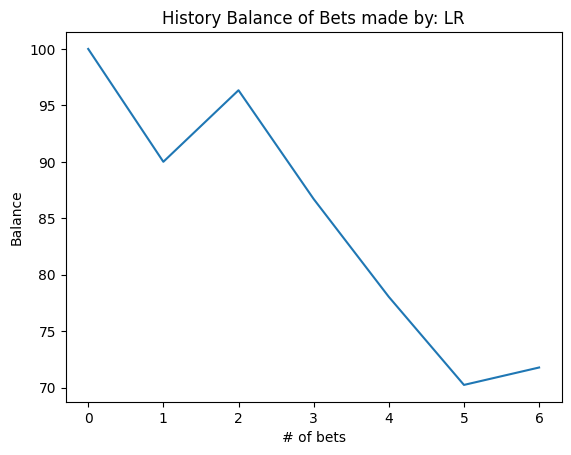

In [10]:
model_name = 'LR'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0) 

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: RF


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,1
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1


# of bets win: 3
% of bets win: 42.857142857142854
Final Balance: 88.12245875251509


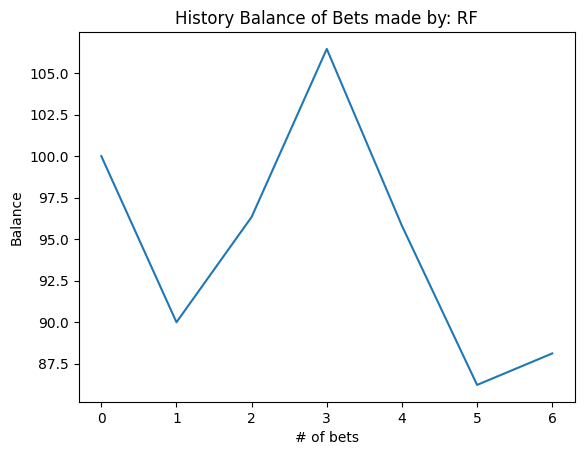

In [11]:
model_name = 'RF'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: GB


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,1
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1


# of bets win: 3
% of bets win: 42.857142857142854
Final Balance: 88.12245875251509


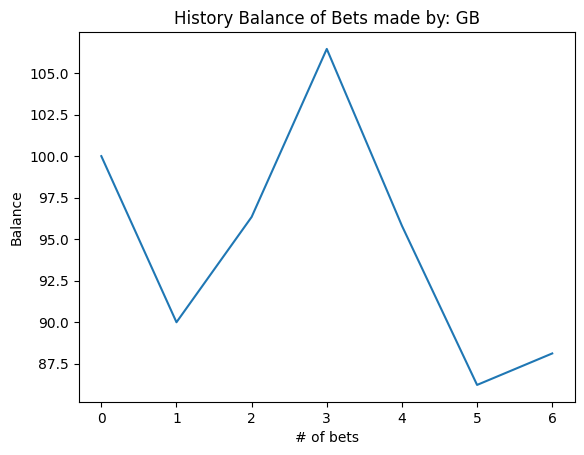

In [12]:
model_name = 'GB'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: SVM


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1


# of bets win: 2
% of bets win: 28.57142857142857
Final Balance: 71.77394830521591


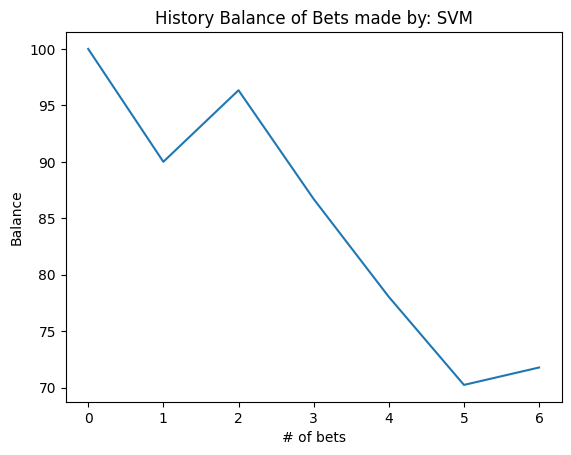

In [13]:
model_name = 'SVM'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')